# Results

In [2]:
from os import makedirs
from os.path import join

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes
from matplotlib.legend import Legend


plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{cmbright}',
    'text.usetex': True,
    'font.family': 'serif',
})
color_palette = sns.color_palette('deep')
plt.rc('grid', linestyle="dotted", color='lightgrey')

results_dir = '../rpaper'
plots_dir = 'paper_plots'

arch_name = {
    'convnext-atto': 'ConvnextAtto',
    'convnext-tiny': 'ConvNextTiny',
    'convnextv2-atto': 'Convnextv2Atto',
    'convnextv2-nano': 'Convnextv2Nano',
    'convnextv2-tiny': 'Convnextv2Tiny',
    'densenet121': 'DenseNet121',
    'densenet161': 'DenseNet161',
    'mobilenetv3-small-075': 'MobileNetV3-Small-0.75',
    'mobilenetv3-large-100': 'MobileNetV3-Large-1.0',
    'mobilevitv2-050': 'MobileViTv2-0.5',
    'mobilevitv2-100': 'MobileViTv2-1.0',
    'mobilevitv2-200': 'MobileViTv2-2.0',

}

def format_pm(s: str) -> str:
    if isinstance(s, str) and '±' in s:
        return s.replace('±', '\\pm')
    else:
        return s

makedirs(plots_dir, exist_ok=True)

### Arch

In [2]:
def load_arch_df():
    df = pd.read_csv(join(results_dir, 'arch_batch-size-48', 'exp_mtst.csv'))
    df['Arch'] = df['run']
    df['Unseen'] = df['unseen']
    df['Seen'] = df['seen']
    df['HM'] = df['hm']
    df = df[['Arch', 'Unseen', 'Seen', 'HM']]
    df = df.set_index('Arch')

    df_params_macs = pd.DataFrame(
        [
            # Efficient
            ('mobilenetv3-small-075',  1.02,  0.12, 'conv'),
            ('mobilevitv2-050',        1.11,  1.05, 'tsfm'),
            ('mobilenetv3-large-100',  4.20,  0.63, 'conv'),
            ('mobilevitv2-100',        4.39,  4.08, 'tsfm'),
            ('convnext-atto',          3.37,  1.62, 'conv'),
            # Large
            ('densenet121',           6.95,   8.33, 'conv'),
            ('densenet161',           26.47, 22.70, 'conv'),
            ('convnext-tiny',         27.82, 28.60, 'conv'),
            ('mobilevitv2-200',       17.42, 16.11, 'tsfm'),
        ],
        columns=['Arch', 'Params', 'MACs', 'CP']
    ).set_index('Arch')


    df = pd.concat([df_params_macs, df], axis=1, join="inner")
    df = df.reset_index()
    df = df.replace(arch_name)
    df = df[['Arch', 'Seen',  'Unseen', 'HM', 'Params', 'MACs', 'CP']]
    return df


arch_df = load_arch_df()
arch_df

FileNotFoundError: [Errno 2] No such file or directory: '../rpaper/arch_batch-size-48/exp_mtst.csv'

In [ ]:
def generate_arch_plot(df: pd.DataFrame):

    df = df.copy()
    df['Unseen'] = df['Unseen'].str[:5].astype(float)
    df['Seen'] = df['Seen'].str[:5].astype(float)
    df['HM'] = df['HM'].str[:5].astype(float)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    ax0: Axes = ax0
    ax1: Axes = ax1

    cp_color = {'conv': color_palette[0], 'tsfm': color_palette[1]}
    colors = [cp_color[cp] for cp in df['CP']]
    # _color = color[:len(df)]

    df.plot.scatter('Params', 'HM', ax=ax0, c=colors)
    df.plot.scatter('MACs', 'HM', ax=ax1, c=colors)

    for x, y, arch in zip(df['Params'], df['HM'], df['Arch']):
        if arch == 'MobileNetV3-Large-1.0':
            ax0.text(x+0.5, y, f'{arch}', ha='left', va='top', fontsize='small')
        else:
            ax0.text(x+0.5, y, f'{arch}', ha='left', va='bottom', fontsize='small')
    xmin, xmax = ax0.get_xlim()
    ax0.set_xlim(xmin, xmax + 0.35 * (xmax - xmin))
    ax0.tick_params(axis='both', which='major', labelsize='small', )

    for x, y, arch in zip(df['MACs'], df['HM'], df['Arch']):
        if arch == 'MobileNetV3-Large-1.0':
            ax1.text(x+0.5, y, f'{arch}', ha='left', va='top', fontsize='small')
        else:
            ax1.text(x+0.5, y, f'{arch}', ha='left', va='bottom', fontsize='small')
    xmin, xmax = ax1.get_xlim()
    ax1.set_xlim(xmin, xmax + 0.35 * (xmax - xmin))
    ax1.tick_params(axis='both', which='major', labelsize='small')

    ax0.set_ylabel('AUC-ROC HM')
    ax0.set_xlabel('Params (M)')
    ax1.set_xlabel('MACs (G)')
    ax1.set_yticklabels([])
    ax1.yaxis.label.set_visible(False)

    conv_patch = mpatches.Patch(color=cp_color['conv'], label='ConvNet')
    tsfm_patch = mpatches.Patch(color=cp_color['tsfm'], label='Transformer')
    ax1.legend(handles=[conv_patch, tsfm_patch], loc='lower right')

    # plt.xticks(fontsize='small')
    # plt.yticks(fontsize='small')

    ax0.grid()
    ax1.grid()

    plt.tight_layout()
    plt.savefig(join(plots_dir, "params-macs.pdf"))
    plt.show()

generate_arch_plot(arch_df)

### Resolution

In [ ]:
def load_resolution_df():
    df = pd.read_csv(join(results_dir, 'resolution', 'exp_mtst.csv'))
    df[['arch', 'resolution']] = df['run'].str.split('_', expand=True)
    df['Arch'] = df['arch'].astype(str)
    df['Resolution'] = df['resolution'].astype(int)
    df['Unseen'] = df['unseen']
    df['Seen'] = df['seen']
    df['HM'] = df['hm']
    df = df[['Arch', 'Resolution', 'Seen',  'Unseen', 'HM']]
    df = df.replace(arch_name)
    return df

resolution_df = load_resolution_df()
resolution_df

In [ ]:
def generate_resolution_plot(df: pd.DataFrame):
    df = df.copy()
    df['Unseen'] = df['Unseen'].str[:5].astype(float)
    df['Seen'] = df['Seen'].str[:5].astype(float)
    df['HM'] = df['HM'].str[:5].astype(float)

    fig, ax = plt.subplots()
    ax: Axes = ax
    print(plt.figure())

    metrics = {('HM', 1.0, 'solid'), ('Seen', 0.5, 'dashed'), ('Unseen', 0.5, 'dotted')}
    archs = df['Arch'].unique()
    for i, (arch, color) in enumerate(zip(archs, color_palette[:3])):
        arch_df = df[df['Arch'] == arch]
        for metric, alpha, linestyle in metrics:
            ax = arch_df.plot(
                x='Resolution', y=metric,
                ax=ax,
                marker='.', linestyle=linestyle,
                alpha=alpha, color=color,
                # label=f'{metric} {arch}'
            )
            ax.get_legend().remove()

        leg = Legend(ax, ax.get_lines()[-3:],
                     ['HM', 'Unseen', 'Seen'],
                     title=arch,
                     fontsize='x-small',
                     edgecolor=color,
                     loc='lower right')
        bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
        x_offset = i * 0.18
        bb.x0 -= x_offset
        bb.x1 -= x_offset
        leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
        ax.add_artist(leg)

    # ax.legend(archs)
    ax.set_xticks(df['Resolution'].unique())
    ax.set_xlabel('X-Ray Resolution')
    ax.set_ylabel('AUC-ROC')

    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.tick_params(axis='both', which='minor', labelsize='small')

    ax.grid()
    fig.tight_layout()
    fig.savefig(join(plots_dir, 'resolution.pdf'))


generate_resolution_plot(resolution_df)

### Subpop Age

In [ ]:
def load_age_df():
    df = pd.read_csv(join(results_dir, 'shift_pop', 'exp_mtst.csv'))
    df = df[df.run.str.startswith('age_decade')]
    df['Decade'] = df['run'].str.split('_', expand=True)[1].str[6:].astype(int)
    df['Unseen'] = df['unseen']
    df['Seen'] = df['seen']
    df['HM'] = df['hm']
    df = df[['Decade', 'Seen',  'Unseen', 'HM']]
    return df

age_df = load_age_df()
age_df


In [ ]:
def generate_age_plot(df: pd.DataFrame):
    df = df.copy()
    df['Unseen'] = df['Unseen'].str[:5].astype(float)
    df['Seen'] = df['Seen'].str[:5].astype(float)
    df['HM'] = df['HM'].str[:5].astype(float)

    fig, ax = plt.subplots()
    ax: Axes = ax
    print(plt.figure())

    df.plot(
        x='Decade', y='HM',
        ax=ax,
        marker='.', linestyle='solid',
        color=color_palette[0]
    )

    df.plot(
        x='Decade', y='Unseen',
        ax=ax,
        marker='.', linestyle='dotted',
        alpha=0.5, color=color_palette[0]
    )

    df.plot(
        x='Decade', y='Seen',
        ax=ax,
        marker='.', linestyle='dashed',
        alpha=0.5, color=color_palette[0]
    )

    labels = ['[10, 20]', '[21, 30]', '[31, 40]', '[41, 50]',
              '[51, 60]', '[61, 70]', '[71, 80]']
    ax.set_xticks(range(2, 9), labels)
    ax.set_xlabel('Decade')
    ax.set_ylabel('HM')

    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.tick_params(axis='both', which='minor', labelsize='small')

    ax.grid()
    fig.tight_layout()
    fig.savefig(join(plots_dir, 'subpop_age.pdf'))


generate_age_plot(age_df)

### From Generalized FSL to Standard FSL

In [ ]:
results_dir = '../../Meta-CXR-dev-run/rpaper'

def load_gfsl_df(

    ):
    df = pd.read_csv(join(results_dir, 'gfsl', 'exp_mtst.csv'))

    df[['n-way', 'n-unseen', 'k-shot']] = df['run'].str.split('_', expand=True)
    df['n-way'] = df['n-way'].str[5:].astype(int)
    df['n-unseen'] = df['n-unseen'].str[7:].astype(int)
    df['k-shot'] = df['k-shot'].str[6:].astype(int)
    df['Unseen'] = df['unseen']
    df['Seen'] = df['seen']
    df['HM'] = df['hm']

    df = df[['n-way', 'n-unseen', 'k-shot', 'Seen',  'Unseen', 'HM']]
    return df

gfsl_df = load_gfsl_df()
with open('gfsl.md', 'w') as f:
    f.write(gfsl_df.to_markdown(index=False) + '\n')
with open('gfsl.tex', 'w') as f:
    formatters = [format_pm] * gfsl_df.shape[1]
    f.write(gfsl_df.to_latex(index=False, formatters=formatters))
gfsl_df

In [ ]:
def generate_gfsl_k_shot(df, k_shot, ax: Axes):

    n_ways = (3, 4, 5)
    num_n_ways = len(n_ways)
    colors = color_palette[:num_n_ways]

    for n_way, color in zip(n_ways, colors):
        subdf = df[df['n-way'] == n_way]

        subdf.plot(x='n-unseen', y='HM',
                   ax=ax,
                   marker='.', linestyle='solid',
                   color=color)
        subdf.plot(x='n-unseen', y='Unseen',
                   ax=ax,
                   marker='.', linestyle='dotted',
                   color=color, alpha=0.5)
        subdf.plot(x='n-unseen', y='Seen',
                   ax=ax,
                   marker='.', linestyle='dashed',
                   color=color, alpha=0.5)

        ax.get_legend().remove()


        if k_shot != 1:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('AUC-ROC')

        if k_shot != 5:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('$n$-unseen')

        if k_shot == 15:
            leg = Legend(ax, ax.get_lines()[-3:],
                        ['HM', 'Unseen', 'Seen'],
                        title=f'{n_way}-way',
                        fontsize='x-small',
                        edgecolor=color,
                        loc='lower right')
            bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
            x_offset = (n_way - 5) * 0.25
            bb.x0 += x_offset
            bb.x1 += x_offset
            leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
            ax.add_artist(leg)

        ax.set_title(f'at least {k_shot}-shot')
        ax.tick_params(axis='both', which='major', labelsize='small')
        ax.tick_params(axis='both', which='minor', labelsize='small')
        ax.grid()
        ax.set_ylim(55, 90)


def generate_gfsl_group_by_k_shot(df):
    df = df.copy()

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    for (k_shot, k_shot_df), ax in zip(df.groupby('k-shot'), axs):
        k_shot_df = k_shot_df.drop(columns=['k-shot'])
        with open(f'gfsl_{k_shot:02d}-shot.tex', 'w') as f:
            formatters = [format_pm] * k_shot_df.shape[1]
            f.write(k_shot_df.fillna(' '*12).to_latex(index=False, formatters=formatters))
        print(k_shot_df)

        k_shot_df['Unseen'] = k_shot_df['Unseen'].str[:5].astype(float)
        k_shot_df['Seen'] = k_shot_df['Seen'].str[:5].astype(float)
        k_shot_df['HM'] = k_shot_df['HM'].str[:5].astype(float)
        generate_gfsl_k_shot(k_shot_df, k_shot, ax)


    # fig.suptitle('From Generalized to Standard FSL', fontsize=16)
    plt.tight_layout()
    plt.savefig(join(plots_dir, "task_complexity.pdf"))
    plt.show()

generate_gfsl_group_by_k_shot(gfsl_df)


### GFSL BB vs Proto

In [3]:
results_dir = '.'

def load_gfsl_bb_vs_proto_df(

    ):
    df = pd.read_csv(join(results_dir, 'gfsl_batchbased_vs_proto_250630.csv'))

    df[['n-way', 'n-unseen', 'k-shot']] = df['Run'].str.split('_', expand=True)
    df['n-way'] = df['n-way'].str[5:].astype(int)
    df['n-unseen'] = df['n-unseen'].str[7:].astype(int)
    df['k-shot'] = df['k-shot'].str[6:].astype(int)
    df['BatchBased'] = df['BatchBased_HM']
    df['ProtoNet'] = df['ProtoNet_HM']
    # df['HM'] = df['hm']

    df = df[['n-way', 'n-unseen', 'k-shot', 'BatchBased', 'ProtoNet']]
    return df

gfsl_df = load_gfsl_bb_vs_proto_df()
with open('gfsl.md', 'w') as f:
    f.write(gfsl_df.to_markdown(index=False) + '\n')
with open('gfsl.tex', 'w') as f:
    formatters = [format_pm] * gfsl_df.shape[1]
    f.write(gfsl_df.to_latex(index=False, formatters=formatters))
gfsl_df

,n-way,n-unseen,k-shot,BatchBased,ProtoNet
0,3,1,1,68.72±0.33,73.74±0.28
1,3,1,5,74.02±0.34,79.13±0.26
2,3,1,15,78.99±0.30,80.18±0.25
3,3,1,30,81.59±0.26,80.40±0.24
4,3,2,1,66.92±0.21,67.11±0.17
5,3,2,5,74.24±0.17,71.00±0.13
6,3,2,15,78.32±0.15,71.31±0.13
7,3,2,30,80.16±0.15,71.07±0.13
8,3,3,1,56.47±0.13,57.02±0.12
9,3,3,5,62.90±0.13,60.06±0.10


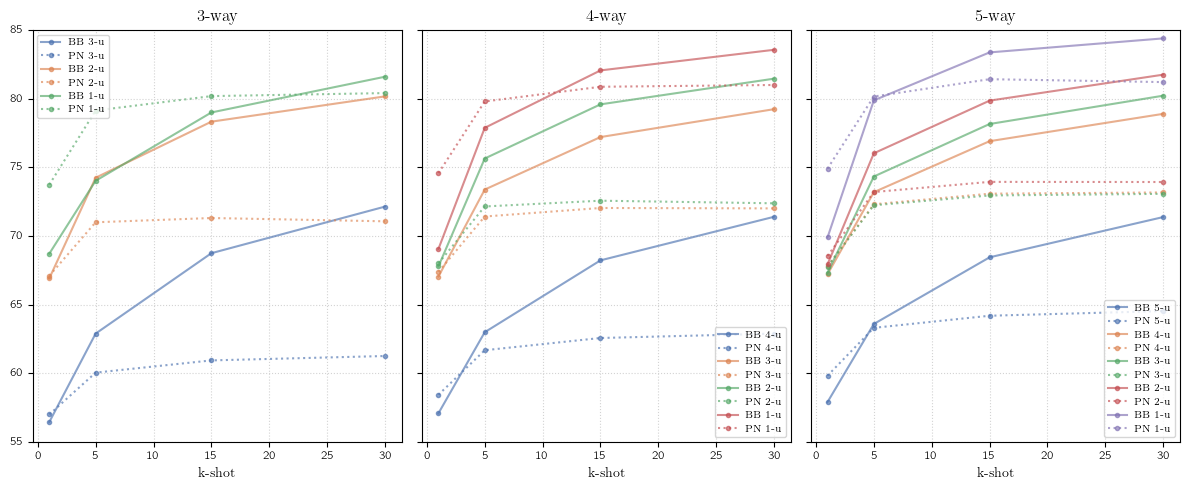

In [114]:
def generate_bb_vs_pn_subplot(df: pd.DataFrame, val: int, ax: Axes):

    color1, color2 = color_palette[:2]

    n_unseens = list(reversed(df['n-unseen'].unique().tolist()))
    total_n_unseen = len(n_unseens)
    linestyles = [':', '-.', '-', '--',  (0, (1, 1))]
    for n_unseen, linestyle, color in zip(n_unseens, linestyles, color_palette):

        n_unseen_df = df[df['n-unseen']  == n_unseen]

        n_unseen_df.plot(
            x='k-shot', y='BatchBased',
            ax=ax,
            linestyle='solid',
            marker='.',
            color=color,
            label=f'BB {n_unseen}-u',
            alpha=0.65
        )

        n_unseen_df.plot(x='k-shot', y='ProtoNet',
            ax=ax,
            linestyle='dotted',
            marker='.',
            color=color,
            label=f'PN {n_unseen}-u',
            alpha=0.65
        )

    if val != 3:
        ax.set_yticklabels([])

    # ax.get_legend().remove()

    # for i, method in enumerate(('ProtoNet', 'BatchBased')):
    #     handles = reversed(ax.get_lines()[-total_n_unseen:])
    #     labels = ['1-u', '2-u', '3-u', '4-u', '5-u'][:total_n_unseen]
    #     leg = Legend(
    #         ax,
    #         handles,
    #         labels,
    #         title=method,
    #         fontsize='x-small',
    #         loc='lower right'
    #     )
    #     bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
    #     x_offset = i * 0.20
    #     bb.x0 -= x_offset
    #     bb.x1 -= x_offset
    #     leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
    #     ax.add_artist(leg)

    ax.set_title(f'{val}-way')
    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.tick_params(axis='both', which='minor', labelsize='small')
    ax.grid()
    ax.set_ylim(55, 85)


def generate_bb_vs_pn_plot(df: pd.DataFrame):
    df = df.copy()
    df['ProtoNet'] = df['ProtoNet'].str[:5].astype(float)
    df['BatchBased'] = df['BatchBased'].str[:5].astype(float)

    col_name = 'n-way'
    values = df[col_name].unique()
    total = len(values)
    plt.rc('legend',fontsize='x-small')
    fig, axs = plt.subplots(1, total, figsize=(4*total, 5))

    for (val, df), ax in zip(df.groupby(col_name), axs):
        df = df.drop(columns=[col_name])
        generate_bb_vs_pn_subplot(df, val, ax)

    plt.tight_layout()
    plt.savefig(join(plots_dir, "bb_vs_pn.pdf"))
    plt.show()

generate_bb_vs_pn_plot(gfsl_df)

In [113]:
df3 = gfsl_df[gfsl_df["n-way"] == 3]
df3 = df3[["BatchBased", "ProtoNet"]]
df3 = df3.rename(columns={"BatchBased": "BatchBased3", "ProtoNet": "ProtoNet3"})
df3 = df3.reset_index(drop=True)

df4 = gfsl_df[gfsl_df["n-way"] == 4]
df4 = df4[["BatchBased", "ProtoNet"]]
df4 = df4.rename(columns={"BatchBased": "BatchBased4", "ProtoNet": "ProtoNet4"})
df4 = df4.reset_index(drop=True)

df5 = gfsl_df[gfsl_df["n-way"] == 5]
df5 = df5[["BatchBased", "ProtoNet"]]
df5 = df5.rename(columns={"BatchBased": "BatchBased5", "ProtoNet": "ProtoNet5"})
df5 = df5.reset_index(drop=True)

df_base = gfsl_df[gfsl_df["n-way"] == 5][["n-unseen", "k-shot"]]
df_base = df_base.reset_index(drop=True)

result_df = pd.concat([df_base, df3, df4, df5], axis=1)

with open('bb_vs_pn.tex', 'w') as f:
    def format_pm(x):
        if isinstance(x, str):
            return x.replace('±', '\\pm') if '±' in x else x
        else:
            return x
    formatters = [format_pm] * result_df.shape[1]
    f.write(result_df.to_latex(index=False, formatters=formatters, na_rep=' '*12))
    result_df.to_latex()
result_df

,n-unseen,k-shot,BatchBased3,ProtoNet3,BatchBased4,ProtoNet4,BatchBased5,ProtoNet5
0,1,1,68.72±0.33,73.74±0.28,69.06±0.27,74.57±0.19,69.90±0.23,74.91±0.16
1,1,5,74.02±0.34,79.13±0.26,77.87±0.22,79.79±0.17,79.87±0.15,80.15±0.13
2,1,15,78.99±0.30,80.18±0.25,82.05±0.18,80.86±0.17,83.36±0.12,81.41±0.13
3,1,30,81.59±0.26,80.40±0.24,83.55±0.15,80.99±0.16,84.38±0.10,81.20±0.12
4,2,1,66.92±0.21,67.11±0.17,67.79±0.16,68.01±0.14,67.94±0.14,68.55±0.13
5,2,5,74.24±0.17,71.00±0.13,75.64±0.11,72.15±0.10,76.02±0.10,73.20±0.10
6,2,15,78.32±0.15,71.31±0.13,79.58±0.10,72.57±0.10,79.85±0.08,73.94±0.09
7,2,30,80.16±0.15,71.07±0.13,81.45±0.10,72.38±0.09,81.74±0.08,73.93±0.08
8,3,1,56.47±0.13,57.02±0.12,67.05±0.16,67.39±0.14,67.33±0.12,67.78±0.12
9,3,5,62.90±0.13,60.06±0.10,73.38±0.12,71.42±0.10,74.33±0.09,72.24±0.08
